# A8Q1 - Classification Algorithm - 194161002

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd                                 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV      # for estimating bandwidth
from sklearn.neighbors import KernelDensity           # for epanechnikov kernel score
from sklearn import metrics                           # for accuracy and f1 score

In [2]:
data = pd.read_csv('CheckerBoardData.csv', header = None, names = ['x1', 'x2', 'y'])

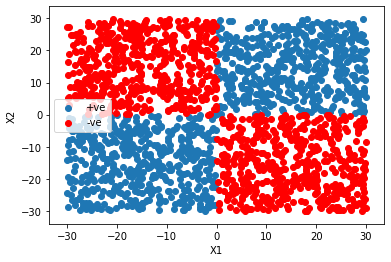

In [3]:
pos = data.iloc[data[data['y'] == 1].index]
neg = data.iloc[data[data['y'] == -1].index]
plt.scatter(pos['x1'], pos['x2'], label = '+ve')
plt.scatter(neg['x1'], neg['x2'], color = 'red', label = '-ve')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

In [4]:
test_size = 0.2
train_data, test_data = train_test_split(data, test_size = test_size)              
x_train, y_train = train_data[train_data.columns[:2]], train_data[train_data.columns[2]]
x_test, y_test = test_data[test_data.columns[:2]], test_data[test_data.columns[2]]

In [5]:
estimator_model = GridSearchCV(KernelDensity(kernel = 'epanechnikov'), 
                    {'bandwidth': np.logspace(-2, 2, 50)}).fit(x_train)
h = estimator_model.best_estimator_.bandwidth
print('Estimated Bandwidth = {} -> for {} % train_data, {} % test_data split'.
      format(h, (1 - test_size) * 100, test_size * 100))
kernel_Epanechnikov = KernelDensity(kernel = 'epanechnikov', bandwidth = h).fit(x_train)

Estimated Bandwidth = 4.094915062380423 -> for 80.0 % train_data, 20.0 % test_data split


In [6]:
def threshSign(x, epsilon = 0.0001):
    if x > epsilon:
        return 1
    elif x < -1 * epsilon:
        return -1
    elif abs(x) < epsilon:
        return 0

In [7]:
def membership_function(distance):
    return np.exp(-0.5 * distance)

In [8]:
def calc_distance(x1, x2, j):
    return 0.5 * (((x1 - clusters_x1_means[j]) ** 2 / clusters_x1_var[j]) +
                  ((x2 - clusters_x2_means[j]) ** 2 / clusters_x2_var[j])) 

In [9]:
def Hj(x1, x2, j):
    numerator = 0
    denominator = 0
    if clusters_type[j] == 'positive':
        return 1
    elif clusters_type[j] == 'negative':
        return -1
    elif clusters_type[j] == 'mixed':
        for i in range(len(clusters_x1_data[j])):
            par = np.array([x1 - clusters_x1_data[j][i], x2 - clusters_x2_data[j][i]]) / h 
            kernel_value = kernel_Epanechnikov.score(par.reshape(1, 2))
            numerator += clusters_y_data[j][i] * kernel_value    
            denominator += kernel_value
        return threshSign(numerator/ denominator)

In [10]:
def H(x1, x2, Sh, distance_lst):
    numerator = 0
    denominator = 0
    for j in Sh:
        numerator += membership_function(distance_lst[j]) * Hj(x1, x2, j)
        denominator += membership_function(distance_lst[j])
    return threshSign(numerator/ denominator)        

## Creating Clusters

In [11]:
n_clusters = 50
Lambda = 3

model = KMeans(n_clusters = n_clusters, random_state = 2).fit(x_train)

clusters_x1_data = list()
clusters_x2_data = list()
clusters_y_data = list()
clusters_x1_var = list()
clusters_x2_var = list()
clusters_x1_means = model.cluster_centers_[:,0]               # cluster means
clusters_x2_means = model.cluster_centers_[:,1]
clusters_type = list()

for i in range(n_clusters):
    cluster = train_data.iloc[np.where(model.labels_ == i)]    # filtering training data based on cluster number
    clusters_x1_data.append(np.array(cluster['x1']))
    clusters_x2_data.append(np.array(cluster['x2']))
    clusters_y_data.append(np.array(cluster['y']))
    covariance = np.cov(cluster['x1'], cluster['x2'])          # Calculating covariance matrix
    clusters_x1_var.append(covariance[0, 0])                         
    clusters_x2_var.append(covariance[1, 1])
    
    if all(cluster['y'] == 1):                                 # Assigning cluster types
        clusters_type.append('positive')
    elif all(cluster['y'] == -1): 
        clusters_type.append('negative')
    else:
        clusters_type.append('mixed')   

## Predicting test data labels

In [12]:
y_pred = list()
for i in range(len(x_test)):                              # for each test data point
    distance_lst = list()
    Sh = list()
    for cluster_number in range(n_clusters):                 # calculating distance and set Sh for every cluster
        x1 = np.array(x_test['x1'])[i]
        x2 = np.array(x_test['x2'])[i]
        distance = calc_distance(x1, x2, cluster_number)
        distance_lst.append(distance)
        
        if distance <= Lambda ** 2:
            Sh.append(cluster_number)
    if Sh:                                                   # predicting labels
        label = H(x1, x2, Sh, distance_lst)
    
    elif not Sh:
        r = distance_lst.index(min(distance_lst))
        label = Hj(x1, x2, r)
        
    y_pred.append(label)

y_pred = np.array(y_pred)

In [13]:
print('Classifier Accuracy = {} %'.format(metrics.accuracy_score(y_test, y_pred) * 100))

Classifier Accuracy = 96.0 %


In [14]:
print('Classifier F1 Score =', metrics.f1_score(y_test, y_pred))

Classifier F1 Score = 0.9615384615384616
